In [1]:

!tar -xzvf "/content/drive/MyDrive/Python/Diplomatiki/MIA_purchase_dataset/dataset_purchase.tgz" -C "/content/"

!mv "/content/dataset_purchase" "/content/dataset_purchase.csv"


dataset_purchase


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ExponentialLR
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import numpy as np
import random
import torch
import os
import pandas as pd
import numpy as np

def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")


def create_df_with_membership_status_using_model_outputs(model, member_df, non_member_df):

    ''' create a dataframe from the outputs of a model
    and add a column refering to the membership status of each record '''

    member_tensor = torch.tensor(member_df.values, dtype=torch.float32)
    non_member_tensor = torch.tensor(non_member_df.values, dtype=torch.float32)

    # use the provided model to generate outputs
    model.eval()
    member_outputs =  F.softmax(model(member_tensor), dim=1)
    non_member_outputs = F.softmax(model(non_member_tensor), dim=1)

    in_df = pd.DataFrame(member_outputs.detach().numpy())
    in_df['membership'] = True

    out_df = pd.DataFrame(non_member_outputs.detach().numpy())
    out_df['membership'] = False

    concatenated_df = pd.concat([in_df, out_df])

    return concatenated_df

In [3]:
import pandas as pd
df = pd.read_csv('/content/dataset_purchase.csv')
set_seed(42)


Random seed set as 42


##### Import Pre-Trained Binary Classifier (Attack Model )

In [ ]:
import joblib

set_seed(42)

FOLDER_NAME = 'Unlearning/full_data_target_model'
folder_path = f'/content/drive/MyDrive/Python/Diplomatiki/MIA_purchase_dataset/{FOLDER_NAME}'
target_model = torch.jit.load(f'{folder_path}/full_data_target_model.pt')

#target_model_train_data = pd.read_csv(f'{folder_path}/train_dataset.csv') # used as member data
target_model_train_data = pd.read_csv(f'/content/drive/MyDrive/Python/Diplomatiki/MIA_purchase_dataset/Unlearning/retain_data_target_model/forget_dataset.csv') # use this as the default forget set
# target_model_train_data = pd.read_csv(f'/content/drive/MyDrive/Python/Diplomatiki/MIA_purchase_dataset/Unlearning/retain_data_target_model/train_dataset.csv')

folder_name = f'Unlearning'
folder_path = f"/content/drive/MyDrive/Python/Diplomatiki/MIA_purchase_dataset/{folder_name}"
attack_model = joblib.load(folder_path + "/attack_model_pre_trained.joblib")

never_seen_before_data_df = df.iloc[90_000:] # part of them to be used as non member data

# print(never_seen_before_data_df.shape)

X_member_df = target_model_train_data.copy()

X_non_member_df = never_seen_before_data_df.sample(n=len(X_member_df), replace=False).drop(columns=never_seen_before_data_df.columns[0], axis=1)

print(X_member_df.shape)
print(X_non_member_df.shape)

dataset_from_target_model_outputs = create_df_with_membership_status_using_model_outputs(target_model, X_member_df, X_non_member_df)
# dataset_from_target_model_outputs

Random seed set as 42
(4000, 600)
(4000, 600)


##### Perform MIA on the target model using the attack model

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

set_seed(42)

# TODO: Change variable names here

X_attack = dataset_from_target_model_outputs.drop(columns=['membership'])
y_attack = dataset_from_target_model_outputs['membership']

y_attack_pred = attack_model.predict(X_attack)
print("True values: ", np.count_nonzero(y_attack_pred == True))
print("False values: ", np.count_nonzero(y_attack_pred == False))

test_precision = precision_score(y_attack, y_attack_pred)

test_recall = recall_score(y_attack, y_attack_pred)

test_accuracy = attack_model.score(X_attack, y_attack)

f1 = f1_score(y_attack, y_attack_pred)

print(f"Test F1 Score: {f1:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

Random seed set as 42


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.8s


True values:  38331
False values:  19269


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.8s


Test F1 Score: 0.7749
Test Accuracy: 0.7377
Test Precision: 0.6786
Test Recall: 0.9032


ROC - plot

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.8s


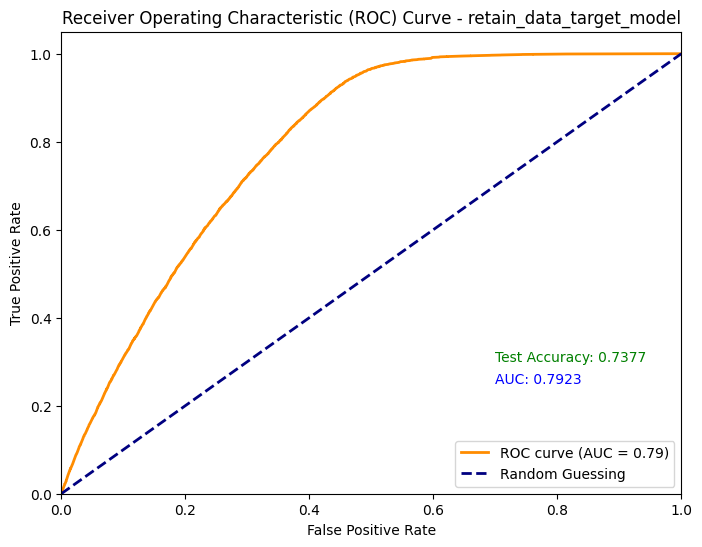

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

X_attack = dataset_from_target_model_outputs.drop(columns=['membership'])
y_attack = dataset_from_target_model_outputs['membership']

y_attack_probs = attack_model.predict_proba(X_attack)[:, 1]

fpr, tpr, thresholds = roc_curve(y_attack, y_attack_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC) Curve - retain_data_target_model')
plt.legend(loc='lower right')


# plt.text(0.7, 0.55, f'batch_size: {batch_size}' , fontsize=10, color='green')
# plt.text(0.7, 0.5, f'hidden_size:{hidden_size}' , fontsize=10, color='green')
# plt.text(0.7, 0.45, f'learning_rate:{learning_rate}', fontsize=10, color='green')
# plt.text(0.7, 0.4, f'epochs:{epochs}', fontsize=10, color='green')
# plt.text(0.7, 0.35, f'number_of_shadows:{number_of_shadows}', fontsize=10, color='green')

plt.text(0.7, 0.3, f'Test Accuracy: {test_accuracy:.4f}', fontsize=10, color='green')
plt.text(0.7, 0.25, f'AUC: {roc_auc:.4f}', fontsize=10, color='blue')


plt.show()

##### code for unlearning full_data_target_model

In [4]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.nn.utils import clip_grad_norm_

set_seed(42)

# load the trained target model
FOLDER_NAME = 'Unlearning/full_data_target_model'
folder_path = f'/content/drive/MyDrive/Python/Diplomatiki/MIA_purchase_dataset/{FOLDER_NAME}'
target_model = torch.jit.load(f'{folder_path}/full_data_target_model.pt')


# my data split for every model, needs to be the same everywhere
target_dataset_head_rows = 50_000

# sto full data modelo kanoume mono train test split, opote epeidi edw theloume to retain kai forget
# na einai uposunolo tou train, kanoume kai edw to train test split stin arxi giana eimaste sigouri
# oti retain forget anikei sto train, omws edw to test_df den to xreiazomaste giati test tha kanoume
# mesa apo to retain ( tha splitaroume auto se kainouria train test) opote vazw _

train_df, test_df = train_test_split(df.head(target_dataset_head_rows), test_size=0.2, random_state=42)
retain_df, forget_df = train_test_split(train_df, test_size=0.1, random_state=42)
print(retain_df.shape, forget_df.shape)

# forget_df = forget_df.iloc[:1000]
# print(forget_df.shape)

# split the retain into train and test for the training process
target_model_df = retain_df.copy()
X = target_model_df.drop(columns=target_model_df.columns[0], axis=1)
y = target_model_df.iloc[:, 0] - 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train.shape, X_test.shape)

# prepare forget data to feed them into unlearning
X_forget = forget_df.drop(columns=forget_df.columns[0], axis=1)
y_forget = forget_df.iloc[:, 0] - 1

class TargetModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TargetModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.tanh = nn.Tanh()
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.tanh(x)
        x = self.output(x)
        return x

def unlearn_target_nn(model, forget_loader, val_loader, criterion, optimizer, epochs, max_val_loss=0.01):

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in tqdm(range(epochs), desc='Epochs'):
        model.train()
        running_loss = 0.0

        for batch_idx, (x_forget, y_forget) in enumerate(forget_loader):
            optimizer.zero_grad()
            outputs_forget = model(x_forget)
            loss_forget = -criterion(outputs_forget, y_forget)
            loss_forget.backward()
            optimizer.step()

            # running_loss += loss_forget.item() * x_forget.size(0)
            running_loss += loss_forget.item()


            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
            val_loss /= len(val_loader)

            if val_loss > max_val_loss:
                print(f"Early stopping because validation loss exceeded the maximum allowed threshold: {max_val_loss:.4f}")
                return

            if batch_idx % 10 == 0: print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx+1}/{len(forget_loader)}] - Forget Loss: {loss_forget.item():.4f} - Validation Loss: {val_loss:.4f}")

            # sweet spot for unlearning
            if epoch == 3 and batch_idx == 10:

                print(epoch, 'epoch', 'batch_idx', batch_idx, 'early stop')
                return

            # # if batch_idx % 10 == 0: print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx+1}/{len(forget_loader)}] - Forget Loss: {loss_forget.item():.4f}")

        # epoch_loss = running_loss / (len(forget_loader) * forget_loader.batch_size)
        # current_lr = scheduler.get_last_lr()[0]
        # scheduler.step()


        # epoch_loss = running_loss / len(train_loader)
        # current_lr = scheduler.get_last_lr()[0]

        # scheduler.step()

        # model.eval()
        # val_loss = 0.0
        # with torch.no_grad():
        #     for inputs, labels in val_loader:
        #         outputs = model(inputs)
        #         loss = criterion(outputs, labels)
        #         val_loss += loss.item()
        # val_loss /= len(val_loader)

        # print(f'\rTrain Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}, Learning Rate: {current_lr:.8f}', end='', flush=True)


if __name__ == "__main__":

    # Set the parameters
    n_features = X_train.shape[1]
    n_classes = len(set(y_train))

    # Convert data to PyTorch tensors
    X_forget_tensor = torch.tensor(X_forget.values, dtype=torch.float32)
    y_forget_tensor = torch.tensor(y_forget.values, dtype=torch.long)

    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

    hidden_size = 128
    learning_rate = 0.003
    epochs = 5
    batch_size = 32

    forget_data = TensorDataset(X_forget_tensor, y_forget_tensor)
    forget_loader = DataLoader(forget_data, batch_size=batch_size, shuffle=True)

    test_data = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.SGD(target_model.parameters(), lr=learning_rate, momentum=0.9)
    optimizer = optim.SGD(target_model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-7)
    # scheduler = ExponentialLR(optimizer, gamma= 1 -  lr_decay)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)



Random seed set as 42
(36000, 601) (4000, 601)
(28800, 600) (7200, 600)


In [5]:
# unlearn_target_nn(target_model, forget_loader, test_loader, criterion,
#                      optimizer, epochs)
unlearn_target_nn(target_model, forget_loader, test_loader, criterion, optimizer, epochs, max_val_loss=0.4)


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1/5], Batch [1/125] - Forget Loss: -0.0032 - Validation Loss: 0.0041
Epoch [1/5], Batch [11/125] - Forget Loss: -0.0051 - Validation Loss: 0.0041
Epoch [1/5], Batch [21/125] - Forget Loss: -0.0034 - Validation Loss: 0.0041
Epoch [1/5], Batch [31/125] - Forget Loss: -0.0050 - Validation Loss: 0.0041
Epoch [1/5], Batch [41/125] - Forget Loss: -0.0036 - Validation Loss: 0.0041
Epoch [1/5], Batch [51/125] - Forget Loss: -0.0026 - Validation Loss: 0.0041
Epoch [1/5], Batch [61/125] - Forget Loss: -0.0042 - Validation Loss: 0.0041
Epoch [1/5], Batch [71/125] - Forget Loss: -0.0037 - Validation Loss: 0.0041
Epoch [1/5], Batch [81/125] - Forget Loss: -0.0047 - Validation Loss: 0.0041
Epoch [1/5], Batch [91/125] - Forget Loss: -0.0058 - Validation Loss: 0.0041
Epoch [1/5], Batch [101/125] - Forget Loss: -0.0066 - Validation Loss: 0.0041
Epoch [1/5], Batch [111/125] - Forget Loss: -0.0042 - Validation Loss: 0.0041
Epoch [1/5], Batch [121/125] - Forget Loss: -0.0038 - Validation Loss: 0.00

eval the model on test_df data

In [6]:
import torch
import numpy as np
from sklearn.metrics import precision_score, recall_score
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ExponentialLR
from tqdm.notebook import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import random
import os

# my data split for every model, needs to be the same everywhere
target_dataset_head_rows = 50_000

#  edw gia test tha paroume to arxiko split se train test kai tha paroume to test df
# to test_df edw den to exei dei sto train tou pote to  full_data_target_model
# opote me to test_df mporoume na doume pws htan prin to unlearning to modelo mas
# kai pws ta paei meta afotou exei faei ligo damage
train_df, test_df = train_test_split(df.head(target_dataset_head_rows), test_size=0.2, random_state=42)
retain_df, forget_df = train_test_split(train_df, test_size=0.1, random_state=42) # not used here


learning_rate = 0.01
lr_decay = 1e-7

# split the retain into train and test
X_test = test_df.drop(columns=test_df.columns[0], axis=1)
y_test = test_df.iloc[:, 0] - 1
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

target_model.to(X_test_tensor.device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(target_model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-7)
scheduler = ExponentialLR(optimizer, gamma= 1 -  lr_decay)

target_model.eval()
with torch.no_grad():
    target_test_outputs = target_model(X_test_tensor)
    target_test_loss = criterion(target_test_outputs, y_test_tensor)

    target_test_predictions = torch.argmax(target_test_outputs, dim=1).cpu().numpy()
    y_test_array = y_test_tensor.cpu().numpy()

    # Calculate accuracy
    target_test_accuracy = (target_test_predictions == y_test_array).mean()

    # Calculate precision and recall
    precision = precision_score(y_test_array, target_test_predictions, average='weighted', zero_division=0)
    recall = recall_score(y_test_array, target_test_predictions, average='weighted', zero_division=0)

print('Model evaluation performance on test_df data')
print(f'Test Loss: {target_test_loss.item():.4f}, Accuracy: {target_test_accuracy:.4f}')
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}')
# Test Loss: 0.5175, Accuracy: 0.8266
# Precision: 0.8281, Recall: 0.8266


Model evaluation performance on test_df data
Test Loss: 0.5278, Accuracy: 0.8246
Precision: 0.8266, Recall: 0.8246


Evaluate unlearning using MIA

Random seed set as 42
(4000, 600)
(4000, 600)


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s


True values:  5137
False values:  2863


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s


Test F1 Score: 0.7462
Test Accuracy: 0.7101
Test Precision: 0.6636
Test Recall: 0.8522


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s


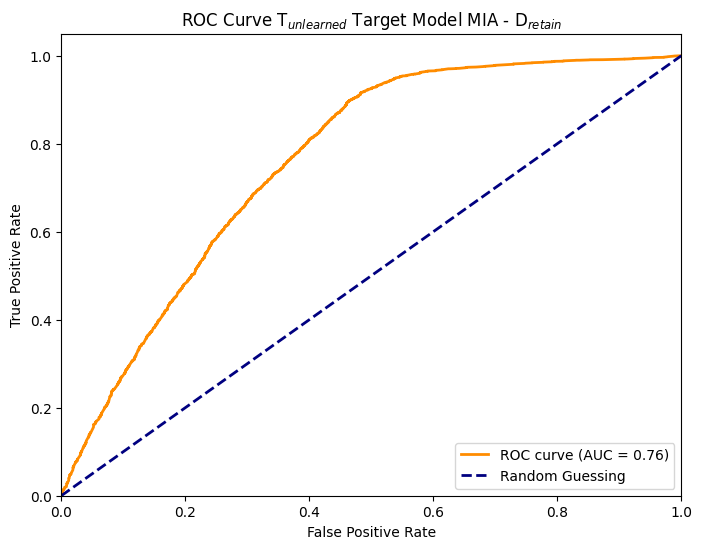

In [7]:
import joblib
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

set_seed(42)

FOLDER_NAME = 'Unlearning/full_data_target_model'

folder_path = f'/content/drive/MyDrive/Python/Diplomatiki/MIA_purchase_dataset/{FOLDER_NAME}'

# here test the model both on forget set and on retain set, mia should be bad on forget set and good on retain set
target_model_train_data = X_forget

# X_retain = retain_df.drop(columns=retain_df.columns[0], axis=1)
# target_model_train_data = X_retain

# target_model_train_data = pd.read_csv(f'/content/drive/MyDrive/Python/Diplomatiki/MIA_purchase_dataset/Unlearning/retain_data_target_model/train_dataset.csv')


folder_name = f'Unlearning'

folder_path = f"/content/drive/MyDrive/Python/Diplomatiki/MIA_purchase_dataset/{folder_name}"

attack_model = joblib.load(folder_path + "/attack_model_pre_trained.joblib")

never_seen_before_data_df = df.iloc[90_000:] # part of them to be used as non member data


X_member_df = target_model_train_data.copy()

X_non_member_df = never_seen_before_data_df.sample(n=len(X_member_df), replace=False).drop(columns=never_seen_before_data_df.columns[0], axis=1)

print(X_member_df.shape)
print(X_non_member_df.shape)

dataset_from_target_model_outputs = create_df_with_membership_status_using_model_outputs(target_model, X_member_df, X_non_member_df)


X_attack = dataset_from_target_model_outputs.drop(columns=['membership'])
y_attack = dataset_from_target_model_outputs['membership']

y_attack_pred = attack_model.predict(X_attack)

print("True values: ", np.count_nonzero(y_attack_pred == True))
print("False values: ", np.count_nonzero(y_attack_pred == False))

test_precision = precision_score(y_attack, y_attack_pred)

test_recall = recall_score(y_attack, y_attack_pred)

test_accuracy = attack_model.score(X_attack, y_attack)

f1 = f1_score(y_attack, y_attack_pred)

print(f"Test F1 Score: {f1:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")


y_attack_probs = attack_model.predict_proba(X_attack)[:, 1]

fpr, tpr, thresholds = roc_curve(y_attack, y_attack_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(r'ROC Curve T$_{unlearned}$ Target Model MIA - D$_{retain}$')
plt.legend(loc='lower right')


# plt.text(0.7, 0.3, f'Test Accuracy: {test_accuracy:.4f}', fontsize=10, color='green')
# plt.text(0.7, 0.25, f'AUC: {roc_auc:.4f}', fontsize=10, color='blue')


plt.show()
# Test F1 Score: 0.5118
# Test Accuracy: 0.5411
# Test Precision: 0.5467
# Test Recall: 0.4810